# Exploratory Data Analysis

**Goal** 

Explore and visualize the demographic, social, and economic structure and dynamics of Cologne over years.

## Setup & Imports

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
plt.style.use("seaborn-v0_8")

import seaborn as sns

import geopandas as gpd


## Load data

In [2]:
DATA_PROCESSED = Path('../data/processed/cologne_data_clean_v2.csv')

df = pd.read_csv(DATA_PROCESSED, low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8892 entries, 0 to 8891
Columns: 105 entries, year to newly_registered_cars_electric
dtypes: float64(98), int64(5), object(2)
memory usage: 7.1+ MB


## Filtered views

In [3]:
CITY = 0
DISTRICTS = 1
NEIGHBORHOODS = 2
STATISTICAL_BLOCKS = 3
SOCIAL_SPACES = 4

df_city = df[df.area_level_code == CITY]
df_districts = df[df.area_level_code == DISTRICTS]
df_neighborhoods = df[df.area_level_code == NEIGHBORHOODS]
df_statistical_blocks = df[df.area_level_code == STATISTICAL_BLOCKS]
df_social_spaces = df[df.area_level_code == SOCIAL_SPACES]

## Quick checks

In [4]:
latest_year = df['year'].max()
earliest_year = df['year'].min()

print(earliest_year, latest_year)

2012 2024


### Missing values (by area level)

In [5]:
df.groupby('area_level_code')[df.select_dtypes(include=["float64"]).columns].apply(lambda x: x.isna().mean()).T

area_level_code,0,1,2,3,4
population_total,0.0,0.000000,0.000000,0.000000,0.055556
non_german_total,0.0,0.000000,0.000000,0.000000,0.055556
non_german_share,0.0,0.000000,0.000000,0.000000,0.055556
migration_background_total,0.0,0.000000,0.000000,0.000000,0.055556
migration_background_share,0.0,0.000000,0.000000,0.000000,0.055556
...,...,...,...,...,...
newly_registered_cars,0.0,0.000000,0.000000,0.014980,0.000000
private_cars_male_holder,0.0,0.000000,0.000000,0.000270,0.000000
registered_cars_private_holder,0.0,0.000000,0.000000,0.000270,0.000000
registered_cars_commercial_use,0.0,0.000000,0.005367,0.066802,0.000000


Most indicators are fully available at city, district, and neighborhood level, while statistical blocks and social spaces show substantial structural missingness. In this project I focus on city (trends) and districts (comparisons).

In [6]:
df_districts.groupby('year')[['newly_registered_cars_electric', 'registered_cars_electric']].apply(lambda x: x.isna().mean())

,newly_registered_cars_electric,registered_cars_electric
year,,
2012,0.222222,0.222222
2013,0.333333,0.222222
2014,0.444444,0.111111
2015,0.555556,0.000000
2016,0.222222,0.000000
2017,0.000000,0.000000
2018,0.000000,0.000000
2019,0.000000,0.000000
2020,0.000000,0.000000


### Co-missingness

In [7]:
# df.isna().corr()

### Duplicates

In [8]:
df.duplicated(subset=['year','area_code']).sum()

np.int64(0)

## Area Levels & Coverage

The dataset is hierarchical and covers multiple administrative levels of Cologne.
Each row represents one area in one year.

Gesamtstadt	(0) - Entire city 

Stadtbezirke (1) - 9 Districts  

Stadtteile (2) - 86 Neighborhoods 

Statistische Quartiere (3) - 570 Statistical blocks

Sozialräume (4) - 18 Social spaces

In [9]:
df['area_level'].value_counts()

area_level
Statistische Quartiere    7410
Stadtteile                1118
Sozialräume                234
Stadtbezirke               117
Gesamtstadt                 13
Name: count, dtype: int64

In [10]:
df.groupby(['year', 'area_level']).size().unstack(fill_value=0)

area_level,Gesamtstadt,Sozialräume,Stadtbezirke,Stadtteile,Statistische Quartiere
year,,,,,
2012,1,18,9,86,570
2013,1,18,9,86,570
2014,1,18,9,86,570
2015,1,18,9,86,570
2016,1,18,9,86,570
2017,1,18,9,86,570
2018,1,18,9,86,570
2019,1,18,9,86,570
2020,1,18,9,86,570


## Spatial structure

In [11]:
GEO_DIR = Path('../data/geo')
SHAPE_DISTRICTS = GEO_DIR / 'Stadtbezirk/Stadtbezirk.shp'
SHAPE_NEIGHBORHOODS = GEO_DIR / 'Stadtteil/Stadtteil.shp'
SHAPE_STAT_BLOCKS = GEO_DIR / 'Statistisches_Quartier/Statistisches_Quartier.shp'

In [12]:
gdf_d = gpd.read_file(SHAPE_DISTRICTS)
gdf_n = gpd.read_file(SHAPE_NEIGHBORHOODS)
gdf_sb = gpd.read_file(SHAPE_STAT_BLOCKS)

Quick look

In [13]:
gdf_d.columns, gdf_d.head(2), gdf_d.crs # The Coordinate Reference System

(Index(['nummer', 'name', 'flaeche', 'geometry'], dtype='object'),
   nummer          name       flaeche  \
 0      1    Innenstadt  1.640542e+07   
 1      2  Rodenkirchen  5.459151e+07   
 
                                             geometry  
 0  POLYGON ((358932.01 5644491.24, 358929.245 564...  
 1  POLYGON ((355322.362 5643194.433, 355334.268 5...  ,
 <Projected CRS: EPSG:25832>
 Name: ETRS89 / UTM zone 32N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: Europe between 6°E and 12°E: Austria; Denmark - onshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore; Spain - offshore.
 - bounds: (6.0, 36.53, 12.01, 84.01)
 Coordinate Operation:
 - name: UTM zone 32N
 - method: Transverse Mercator
 Datum: European Terrestrial Reference System 1989 ensemble
 - Ellipsoid: GRS 1980
 - Prime Meridian: Greenwich)

## Population analysis

### Total population over time on the city level

In [14]:
df_city.groupby('year')['population_total'].apply(lambda x: x.sum())

year
2012    1044555.0
2013    1044070.0
2014    1053528.0
2015    1069192.0
2016    1081701.0
2017    1084795.0
2018    1089984.0
2019    1091819.0
2020    1088040.0
2021    1079301.0
2022    1092118.0
2023    1095520.0
2024    1097519.0
Name: population_total, dtype: float64

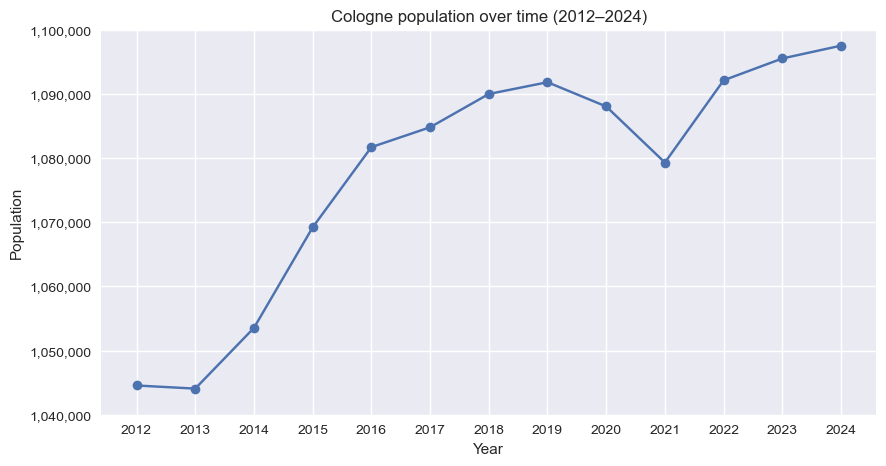

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_city['year'], df_city['population_total'], marker='o')

ax.set_ylim(ymin=1040000.0, ymax=1100000.0)

ax.set_xlabel("Year")
ax.set_ylabel("Population")
ax.set_title(f"Cologne population over time ({earliest_year}–{latest_year})")

ax.set_xticks(df_city['year'])

ax.ticklabel_format(style="plain", axis="y")
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f"{int(x):,}")
)

plt.show()

### Population distribution across districts

(latest year)

In [16]:
df_districts_latest = df_districts[df_districts['year'] == latest_year]
df_districts_latest.groupby('area')['population_total'].apply(lambda x: x.sum()).sort_values(ascending=False)

area
Lindenthal      153935.0
Mülheim         150471.0
Innenstadt      127813.0
Kalk            122378.0
Nippes          117688.0
Porz            116483.0
Rodenkirchen    112883.0
Ehrenfeld       111789.0
Chorweiler       84079.0
Name: population_total, dtype: float64

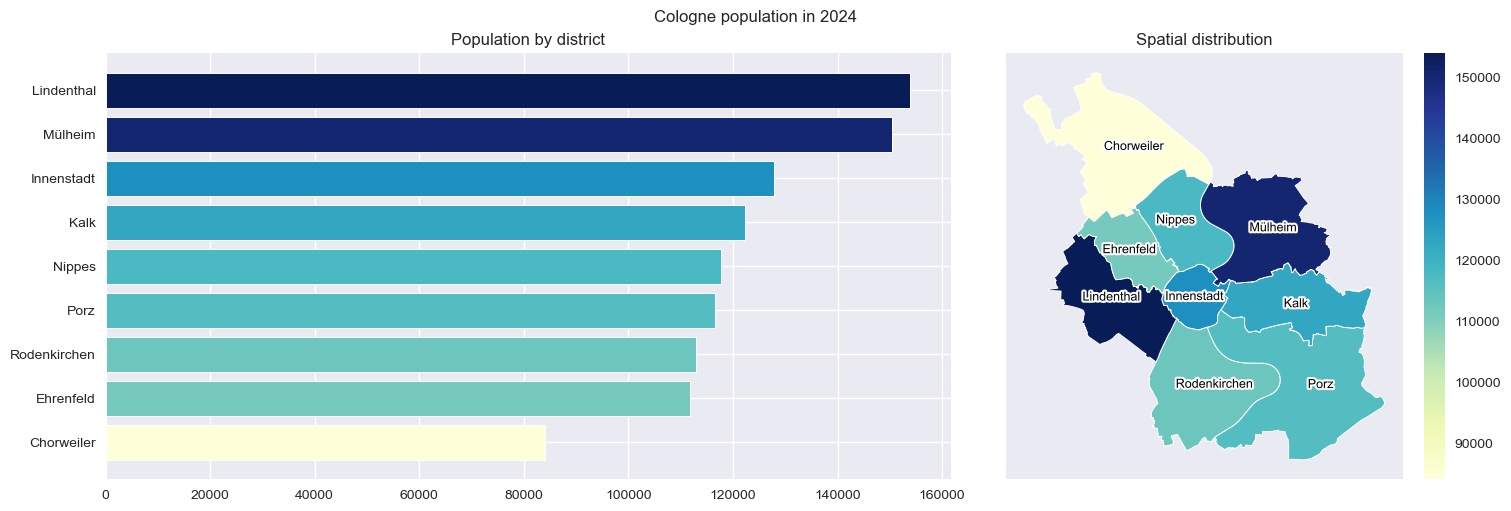

In [17]:
df_temp_dl = df_districts_latest.sort_values('population_total')

gdf_d_2024 = gdf_d.merge(
    df_districts_latest[['area', 'population_total']],
    left_on='name',     
    right_on='area',  
    how='left'
    )

norm = mcolors.Normalize(
    vmin=df_temp_dl['population_total'].min(),
    vmax=df_temp_dl['population_total'].max()
)

cmap = plt.cm.YlGnBu

fig, (ax_bar, ax_map) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True)

ax_bar.barh(
    df_temp_dl['area'], 
    df_temp_dl['population_total'],
    color=cmap(norm(df_temp_dl['population_total'])),
    edgecolor='white',
    linewidth=0.7
    )

ax_bar.set_title("Population by district")


ax_map.add_patch(
    plt.Rectangle(
        (0,0), 1, 1, 
        facecolor="#EAEAF2", 
        transform=ax_map.transAxes, 
        zorder=-1)
    )

gdf_d_2024.plot(
    ax=ax_map,
    column='population_total',
    cmap=cmap,
    norm=norm,
    legend=True,
    edgecolor='white',
    linewidth=0.7,
    )

for _, row in gdf_d_2024.iterrows():
    x, y = row.geometry.representative_point().coords[0]
    ax_map.text(
        x, y,
        row['name'],
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        path_effects=[pe.withStroke(linewidth=3, foreground='white')]
    )

ax_map.set_title("Spatial distribution")
ax_map.axis("off")

fig.suptitle(f"Cologne population in {latest_year}")

plt.show()



### Population change by district over time

In [18]:
df_temp = df_districts.groupby(['area', 'year'], as_index=False)['population_total'].sum()
colors = plt.cm.tab10(range(len(df_temp['area'].unique())))
color_map = {d: c for d, c in zip(df_temp['area'].unique(), colors)}

gdf_d['plot_color'] = gdf_d['name'].map(color_map)

/var/folders/b7/0lrwcbf52xvccvvdz4wbwfkw0000gn/T/ipykernel_2886/3733979575.py:27: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf_d.plot(


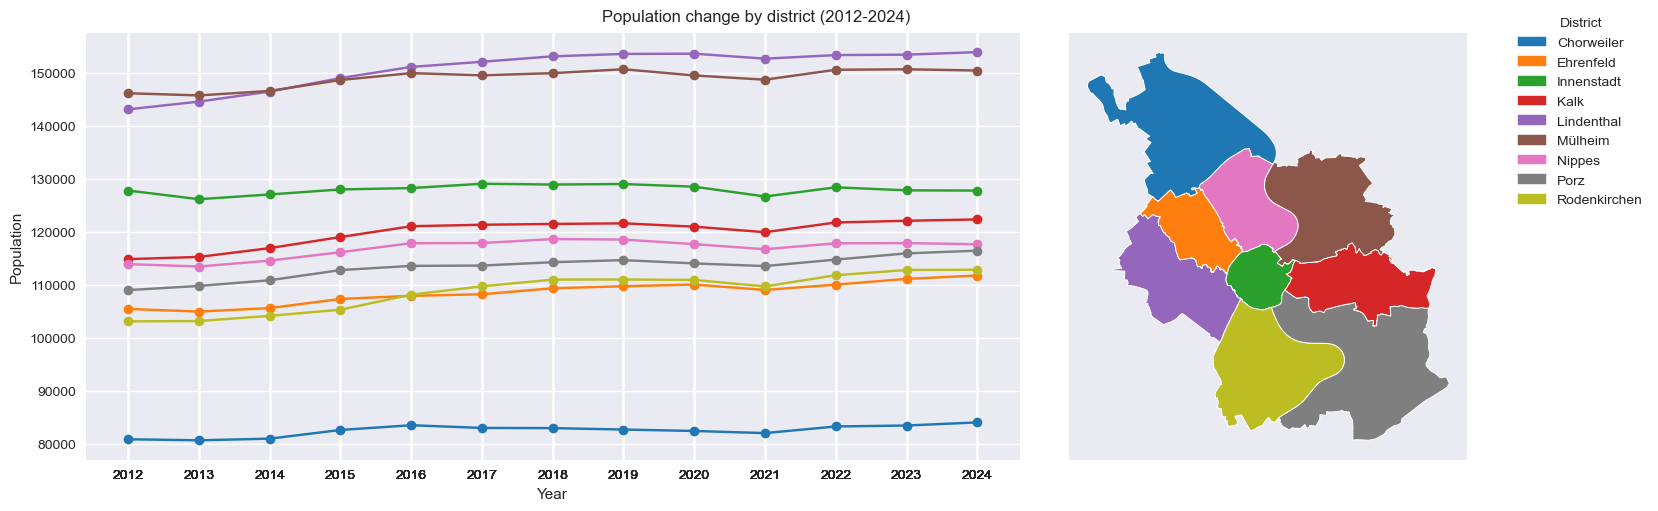

In [19]:
fig, (ax_plot, ax_map) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True)

for area in df_temp['area'].unique():
    a = df_temp[df_temp['area'] == area]
    ax_plot.plot(
        a['year'], 
        a['population_total'], 
        marker='o', 
        label=area, 
        color=color_map[area]
        )
    
ax_plot.set_xticks(df_temp['year'])
    
ax_plot.set_xlabel("Year")
ax_plot.set_ylabel("Population")
# ax_plot.set_title("Population change")

ax_map.add_patch(
    plt.Rectangle(
        (0,0), 1, 1, 
        facecolor="#EAEAF2", 
        transform=ax_map.transAxes, 
        zorder=-1)
    )

gdf_d.plot(
    ax=ax_map, 
    edgecolor='white', 
    column='name', 
    categorical=True, 
    color=gdf_d['plot_color'], 
    linewidth=0.7
    )

# ax_map.set_title("Districts")

ax_map.axis("off")

fig.suptitle(f"Population change by district ({earliest_year}-{latest_year})")

handles = [mpatches.Patch(color=color_map[d], label=d) for d in df_temp['area'].unique()]

fig.legend(
    handles=handles,
    title="District", 
    bbox_to_anchor=(1, 1), 
    loc='upper left'
    )

plt.show()



In [20]:
# pivot1 = df_districts.pivot_table(
#     index='year',
#     columns='area',
#     values='population_total',
#     aggfunc='sum'
# )

# pivot1

In [21]:
pop_by_d = df_districts.groupby(['year', 'area'])['population_total'].sum().unstack()
pop_by_d

area,Chorweiler,Ehrenfeld,Innenstadt,Kalk,Lindenthal,Mülheim,Nippes,Porz,Rodenkirchen
year,,,,,,,,,
2012,80895.0,105493.0,127827.0,114885.0,143149.0,146182.0,113945.0,109039.0,103140.0
2013,80700.0,104984.0,126187.0,115301.0,144606.0,145771.0,113487.0,109827.0,103207.0
2014,81013.0,105647.0,127088.0,116962.0,146505.0,146623.0,114604.0,110902.0,104184.0
2015,82653.0,107373.0,128032.0,119055.0,149045.0,148682.0,116187.0,112819.0,105346.0
2016,83546.0,107957.0,128295.0,121089.0,151150.0,149979.0,117892.0,113611.0,108182.0
2017,83036.0,108256.0,129108.0,121372.0,152117.0,149564.0,117921.0,113670.0,109751.0
2018,83000.0,109386.0,128958.0,121521.0,153149.0,149973.0,118668.0,114306.0,111023.0
2019,82732.0,109770.0,129055.0,121637.0,153600.0,150709.0,118577.0,114699.0,111040.0
2020,82464.0,110088.0,128552.0,121007.0,153644.0,149537.0,117710.0,114076.0,110962.0


## Age structure

Basic features: Age, sex, marital status.
Socioeconomic factors: Income*, employment status.
Housing: household site
Population dynamics: Birth rates, Death rates, and migration.

### Average age over time

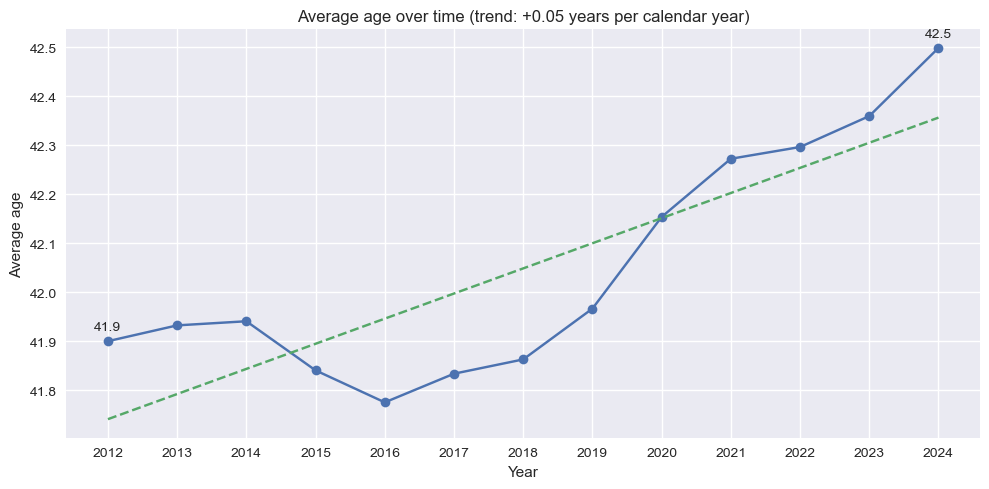

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_city['year'], df_city['avg_age_total'], marker='o')

x = df_city['year']
y = df_city['avg_age_total']
a, b = np.polyfit(x, y, 1) # Least squares polynomial fit y = a*x + b

ax.plot(x, a*x+b, linestyle='--') #trendline

ax.set_xlabel("Year")
ax.set_ylabel("Average age")
ax.set_xticks(df_city['year'])
ax.set_title(f"Average age over time (trend: +{a:.2f} years per calendar year)")

ax.annotate(f"{y.iloc[0]:.1f}", (x.iloc[0], y.iloc[0]), xytext=(0,8), textcoords='offset points', ha='center')
ax.annotate(f"{y.iloc[-1]:.1f}", (x.iloc[-1], y.iloc[-1]), xytext=(0,8), textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()

Average age increased from 41,9 to 42,5. Total chance is +0.6 years over 12 years.

The linear trend shows an increase of 0.05 years per calendar year, indicating a demographic aging process over time.

### Age-group compositions

In [23]:
# age_groups = {
#     'children_00_17' : ['population_00_03', 'population_03_06', 'population_06_15', 'population_15_18'],
#     'young_adults_18_34' : ['population_18_21', 'population_21_35'],
#     'adults_35_59' : ['population_35_60'],
#     'seniors_60_plus' : ['population_60_65', 'population_65_75', 'population_75_80', 'population_80_plus']
# }

age_groups = {
    'children_00_17' : ['00_03', '03_06', '06_15', '15_18'],
    'young_adults_18_34' : ['18_21', '21_35'],
    'adults_35_59' : ['35_60'],
    'seniors_60_plus' : ['60_65', '65_75', '75_80', '80_plus']
}

# Children Youth Working age Pre-retirement (65–74) Elderly 

In [24]:
df_temp = df_city[['year', 'population_total']].copy()

for name, cols in age_groups.items():
    
    pop_cols = [f'population_{c}' for c in cols]
    
    df_temp[name] = df_city[pop_cols].sum(axis=1)
    df_temp[f'{name}_share'] = df_temp[name] / df_temp['population_total'] * 100
    
# check
df_temp['age_groups_sum'] = df_temp[list(age_groups.keys())].sum(axis=1)
df_temp['pop_total_vs_sum'] = df_temp['population_total'] - df_temp['age_groups_sum']
df_temp[['year', 'population_total', 'age_groups_sum', 'pop_total_vs_sum']]

,year,population_total,age_groups_sum,pop_total_vs_sum
0,2012,1044555.0,1044555.0,0.0
684,2013,1044070.0,1044070.0,0.0
1368,2014,1053528.0,1053528.0,0.0
2052,2015,1069192.0,1069192.0,0.0
2736,2016,1081701.0,1081701.0,0.0
3420,2017,1084795.0,1084795.0,0.0
4104,2018,1089984.0,1089984.0,0.0
4788,2019,1091819.0,1091819.0,0.0
5472,2020,1088040.0,1088040.0,0.0
6156,2021,1079301.0,1079301.0,0.0


In [25]:
# fig, ax = plt.subplots(figsize=(10,5))

# # ax.plot(df_temp['year'], df_temp[group_names])

# ax.stackplot(
#     df_temp['year'], df_temp['children_00_17_share'], 
#     df_temp['young_adults_18_34_share'],
#     df_temp['adults_35_59_share'],
#     df_temp['seniors_60_plus_share'],
#     labels=age_groups.keys()
# )

# ax.set_xlabel("Year")
# ax.set_ylabel("Share of population, %")
# ax.set_title('Age groups composition over time')

# ax.legend(title="Age group", bbox_to_anchor=(1, 1), loc='upper left')

# plt.tight_layout()
# plt.show()

In [26]:
cols = {
    'Children (0-17)': 'children_00_17_share',
    'Young adults (18–34)': 'young_adults_18_34_share',
    'Adults (35–59)': 'adults_35_59_share',
    'Seniors (60+)': 'seniors_60_plus_share',
}

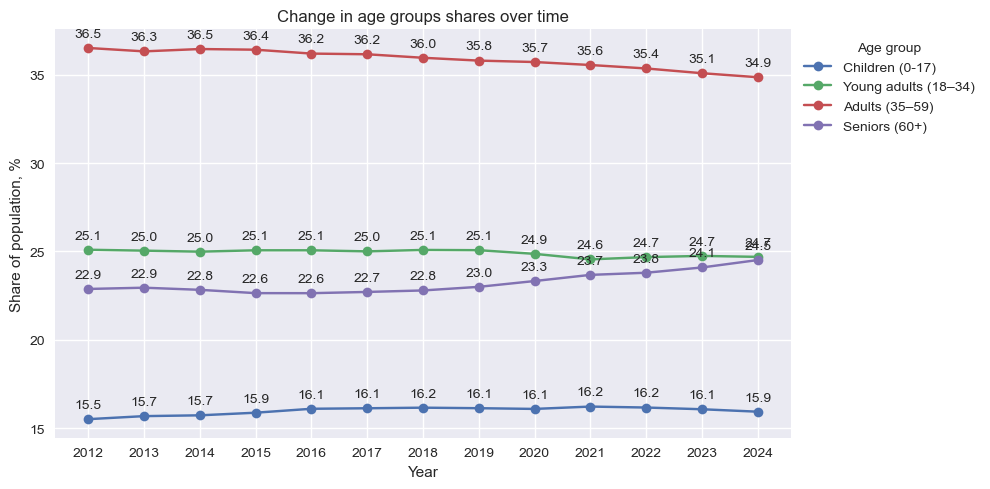

In [27]:
fig, ax = plt.subplots(figsize=(10,5))

for label, col in cols.items():
    ax.plot(df_temp['year'], df_temp[col], marker='o', label=label)
        
    for x, y in zip(df_temp['year'], df_temp[col]):
        # ax.text(x, y+0.5, f"{y:.1f}", fontsize=8, ha='center')
        ax.annotate(f"{y:.1f}", (x, y), xytext=(0, 8), textcoords='offset points', ha='center')

ax.set_xlabel("Year")
ax.set_ylabel("Share of population, %")
ax.set_title("Change in age groups shares over time")
ax.set_xticks(df_temp['year'])
ax.legend(title="Age group", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()


The age groups composition also show a structural shift toward the older population. 

The share of adults 35-64 declined steadely from 36.5% to 34.9%, while senior population increased from 22.9% to 24.5% with faster growth after 2019.

The share of children and young adults remained relatively stable.

In [28]:
# fig, ax = plt.subplots(figsize=(10,5))

# ax.axhline(0, linestyle="--", color='darkgray')

# for label, col in cols.items():
#     baseline = df_temp.loc[df_temp['year']==earliest_year, col].iloc[0]
#     ax.plot(df_temp['year'], df_temp[col]-baseline, marker='o', label=label)

# # def change(col):
# #     baseline = df_temp.loc[df_temp['year']==earliest_year, col].iloc[0]
# #     return df_temp[col] - baseline

# # ax.plot(df_temp['year'], change('children_00_17_share'), color='C0', marker='o', label="Children (0-17)")
# # ax.plot(df_temp['year'], change('young_adults_18_34_share'), color='C1', alpha=0.4, marker='o', label="Young adults (18–34)")
# # ax.plot(df_temp['year'], change('adults_35_59_share'), color='C2', alpha=0.4, marker='o', label="Adults (35–59)")
# # ax.plot(df_temp['year'], change('seniors_60_plus_share'), color='C3', marker='o', label="Seniors (60+)")
    
# ax.set_title(f"Age groups shares change since {earliest_year}")
# ax.set_xlabel("Year")
# ax.set_ylabel("Change, %")
# ax.set_xticks(df_temp["year"])
# ax.legend()

# plt.tight_layout()
# plt.show()

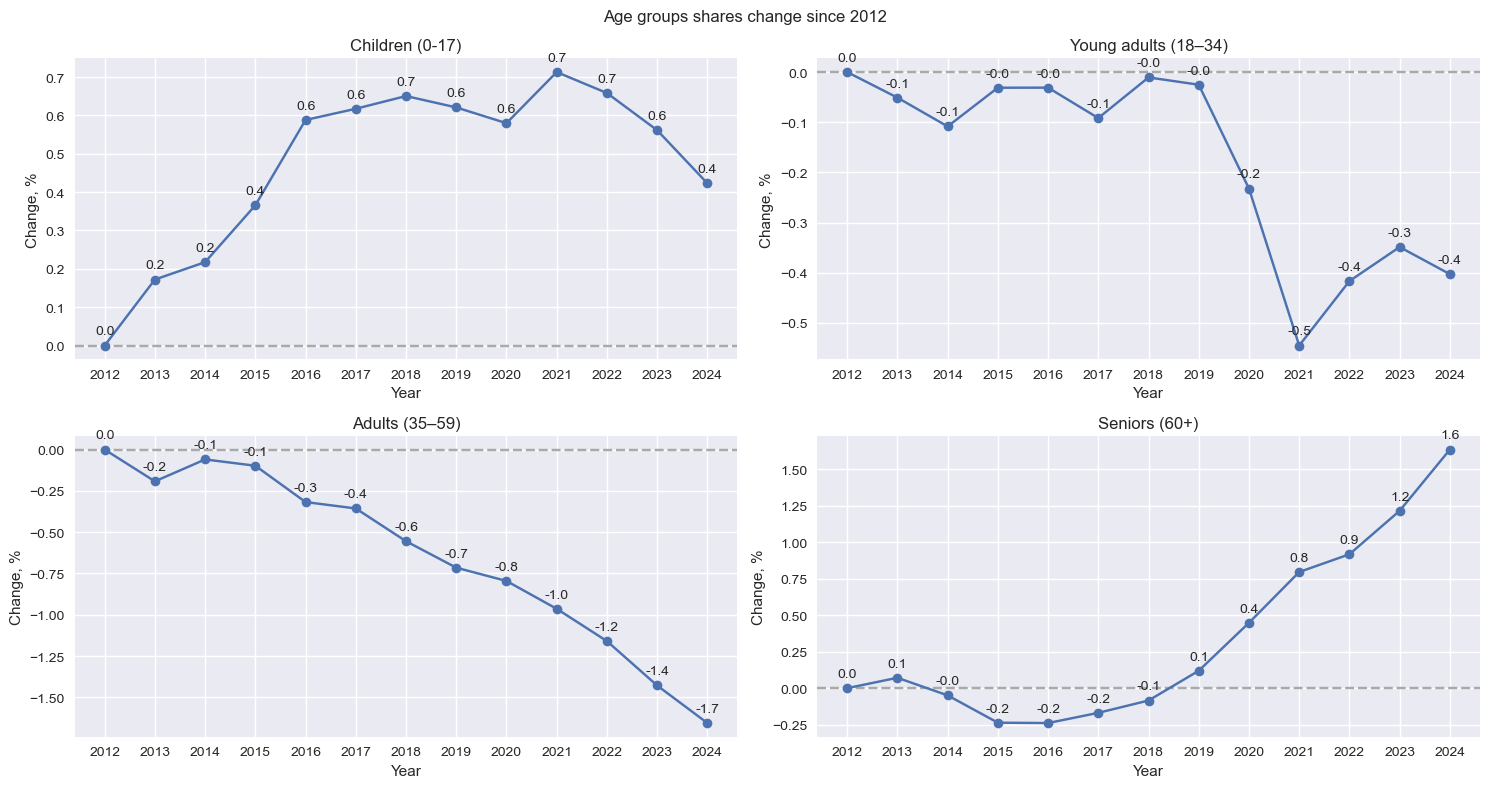

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(15,8)) #, constrained_layout=True)
axs = axs.ravel()

for ax, (label, col) in zip(axs, cols.items()):
        ax.axhline(0, linestyle="--", color='darkgray')
        baseline = df_temp.loc[df_temp['year']==earliest_year, col].iloc[0]
        ax.plot(df_temp['year'], df_temp[col]-baseline, marker='o', label=label)
        
        offset = ((df_temp[col]-baseline).max() - (df_temp[col]-baseline).min()) * 0.05
        
        for x, y in zip(df_temp['year'], df_temp[col]-baseline):
                # ax.text(x, y+offset, f"{y:.1f}", fontsize=8, ha='center')
                ax.annotate(f"{y:.1f}", (x, y), xytext=(0, 8), textcoords='offset points', ha='center')
    
        ax.set_title(f"{label}")
        ax.set_xlabel("Year")
        ax.set_ylabel("Change, %")
        ax.set_xticks(df_temp["year"])

fig.suptitle(f"Age groups shares change since {earliest_year}")
plt.tight_layout()
plt.show()

The figure indicates that:

- seniors increased markedly after 2018 (+1.6% by 2024);
  
- adults declined continuously (-1.7% by 2024)

- children increased only temporarily until 2016.

### Aging index

(how many seniors there are per 100 children)

In [30]:
df_temp['aging_index'] = df_temp['seniors_60_plus'] / df_temp['children_00_17'] * 100

df_temp.groupby('year')['aging_index'].mean()

year
2012    147.529649
2013    146.364736
2014    145.175447
2015    142.639546
2016    140.653180
2017    140.833081
2018    141.065781
2019    142.591204
2020    144.998886
2021    145.954314
2022    147.199597
2023    149.941489
2024    153.879636
Name: aging_index, dtype: float64

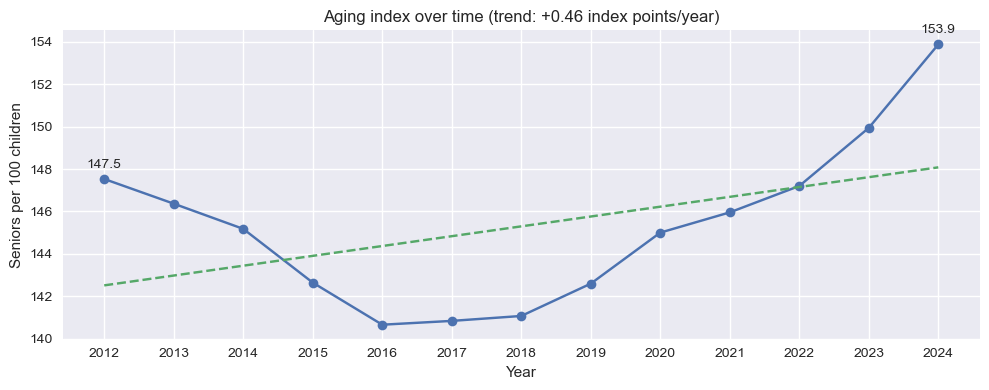

In [31]:
x = df_temp['year'].values
y = df_temp['aging_index'].values
a, b = np.polyfit(x, y, 1)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x, y, marker='o')
ax.plot(x, a*x + b, linestyle='--')

ax.set_title(f"Aging index over time (trend: {a:+.2f} index points/year)")
ax.set_xlabel("Year")
ax.set_ylabel("Seniors per 100 children")
ax.set_xticks(df_temp['year'])

ax.annotate(f"{y[0]:.1f}", (x[0], y[0]), xytext=(0,8), textcoords='offset points', ha='center')
ax.annotate(f"{y[-1]:.1f}", (x[-1], y[-1]), xytext=(0,8), textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()

Each year there are on average 0.46 additional seniors per 100 children.

However,the chart confirms distinct phases:

- 2012-2016 - decline, due to growth of child population and slight decrease of senior population;
  
- 2017-2018 - turning point, likely reflecting stabization of child population and slight growth of senior population;
  
- 2019-2024 - strong acceleration, indicating a gradual intensification of population aging.


### Dependency ratio

(how many dependents (children + seniors) there are per 100 adults)

In [32]:
df_temp['dependency_ratio'] = (df_temp['children_00_17'] + df_temp['seniors_60_plus']) / (df_temp['young_adults_18_34'] + df_temp['adults_35_59']) * 100

df_temp.groupby('year')['dependency_ratio'].mean()

year
2012    62.297779
2013    62.940918
2014    62.741460
2015    62.638005
2016    63.221667
2017    63.486738
2018    63.801206
2019    64.271002
2020    65.050606
2021    66.372398
2022    66.558334
2023    67.117696
2024    67.907246
Name: dependency_ratio, dtype: float64

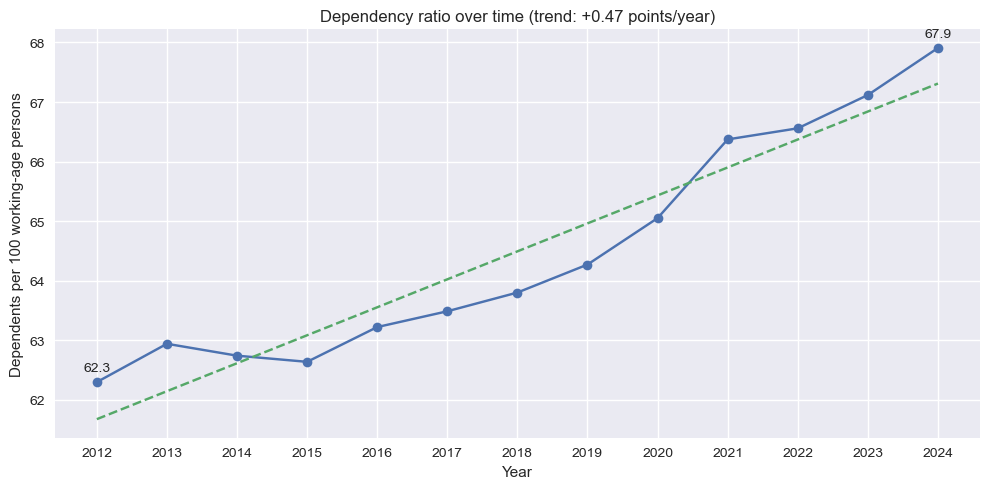

In [33]:
x = df_temp['year'].values
y = df_temp['dependency_ratio'].values
a, b = np.polyfit(x, y, 1)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y, marker='o')
ax.plot(x, a*x+b, linestyle='--')

ax.set_title(f"Dependency ratio over time (trend: {a:+.2f} points/year)")
ax.set_xlabel("Year")
ax.set_ylabel("Dependents per 100 working-age persons")
ax.set_xticks(df_temp['year'])

ax.annotate(f"{y[0]:.1f}", (x[0], y[0]), xytext=(0,8), textcoords='offset points', ha='center')
ax.annotate(f"{y[-1]:.1f}", (x[-1], y[-1]), xytext=(0,8), textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()

Each year there are on average 0.47 additional dependents per 100 working age persons.

The dependency ratio increased from 62.5 to 67.9 by 2024, indicating a continuous increase in demographic pressure on the working age population, primarily due to growth in the senior cohort and a reduction in the adult population.

**Conclusion**

The age analysis demonstrates a clear structural shift toward an older population. 

All examined indicators point to gradual but consistent aging process, characterized by increasing of senior population and the continuous decrease of working age population.

Overall, the transformation of the age structure reflects a long-term trend that is likely to continue in the coming years.

## Sex structure

### Basic sex composition

In [34]:
#quick check
(df_city['population_total'] - df_city['male_residents_total'] - df_city['female_residents_total']).values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [35]:
df_temp = df_city[['year', 'population_total']].copy()

df_temp['male_share'] = df_city['male_residents_total'] / df_temp['population_total'] * 100
df_temp['female_share'] = df_city['female_residents_total'] / df_temp['population_total'] * 100

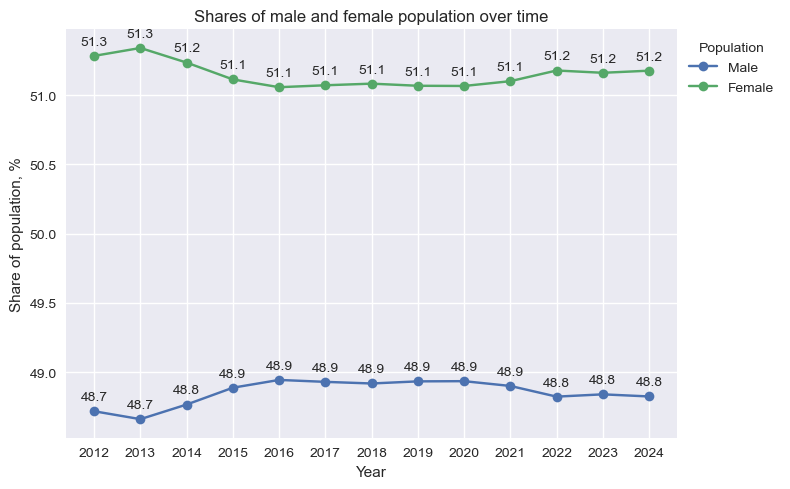

In [36]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df_temp['year'], df_temp['male_share'], marker='o', label='Male')
ax.plot(df_temp['year'], df_temp['female_share'], marker='o', label='Female')

for col in ['male_share', 'female_share']:
        for x, y in zip(df_temp['year'], df_temp[col]):
                # ax.text(x, y+0.1, f"{y:.1f}", fontsize=8, ha='center')
                ax.annotate(f"{y:.1f}", (x, y), xytext=(0, 8), textcoords='offset points', ha='center')

ax.set_title(f"Shares of male and female population over time")
ax.set_xlabel("Year")
ax.set_ylabel("Share of population, %")
ax.set_xticks(df_temp['year'])
plt.legend(title="Population", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

The population shows a stable and slightly female-dominated structure, with women around 51% and no significant changes over time.


### Average age of male and female populations over time

In [37]:
avg_age_groups = [
    ("Male", df_city['avg_age_male']),
    ("Female", df_city['avg_age_female'])
] 

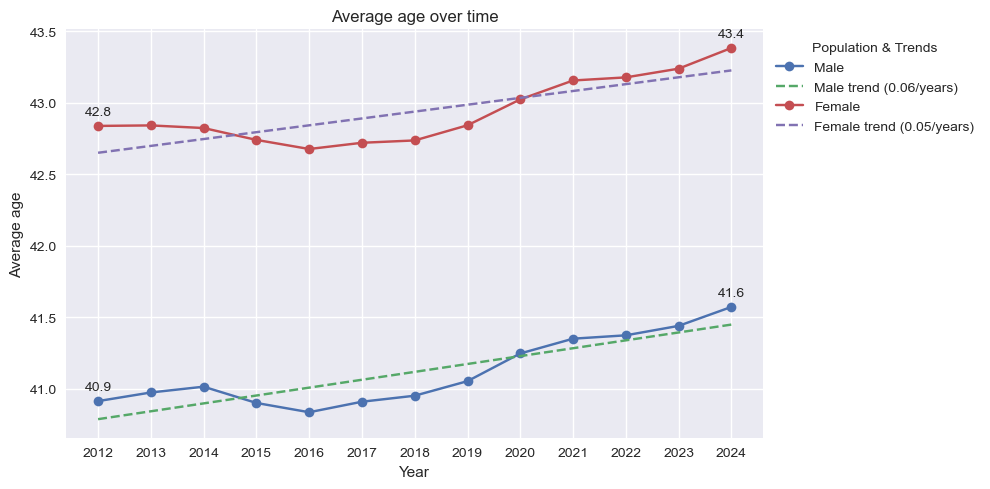

In [38]:
fig, ax = plt.subplots(figsize=(10,5))

years = df_city['year']

for name, values in avg_age_groups:
    
    ax.plot(years, values, marker='o', label=name)
    
    # trendlines
    # polynomial fit y = a*x + b, a - slope, b - intercept
    a, b = np.polyfit(years, values, 1)
    ax.plot(years, a*years+b, linestyle='--', label=f"{name} trend ({a:.2f}/years)")
    
    ax.annotate(f"{values.iloc[0]:.1f}", (years.iloc[0], values.iloc[0]), xytext=(0,8), textcoords='offset points', ha='center')
    ax.annotate(f"{values.iloc[-1]:.1f}", (years.iloc[-1], values.iloc[-1]), xytext=(0,8), textcoords='offset points', ha='center')

ax.set_xlabel("Year")
ax.set_ylabel("Average age")
ax.set_xticks(df_city['year'])
ax.set_title(f"Average age over time")

plt.legend(title="Population & Trends", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

The average age increased for both sexes, confirming a general aging trend.

Women remain consistently older than men over time.

Both trend lines indicate growth, slightly faster for men (+0.06 years per calendar year) than for women (+0.05 years per calendar year). 


### Age-specific sex ratios

Sex ratio (how many males per 100 females)

In [39]:
group_names = {
    'Children (0-17)': 'children_00_17',
    'Young adults (18–34)': 'young_adults_18_34',
    'Adults (35–59)': 'adults_35_59',
    'Seniors (60+)': 'seniors_60_plus',
}

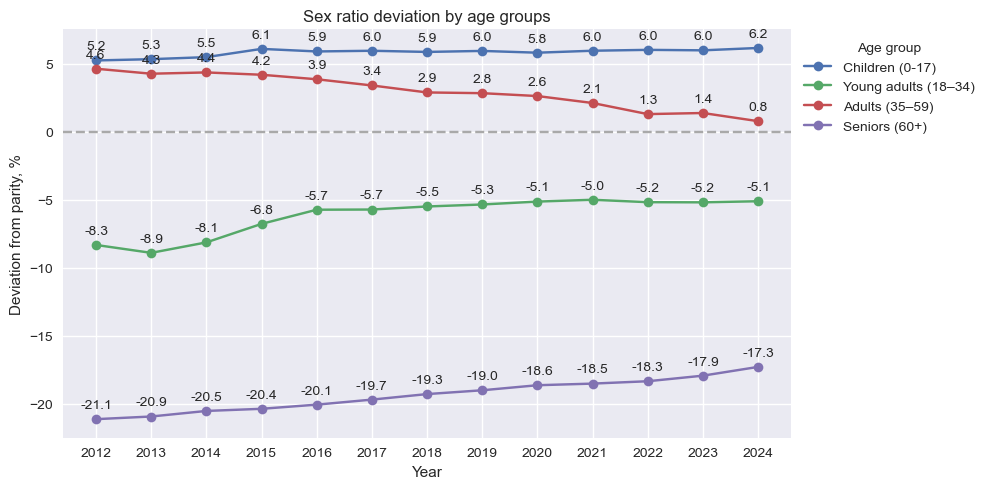

In [40]:
fig, ax = plt.subplots(figsize=(10,5))

plt.axhline(0, color='darkgray', linestyle='--')

for name, cols in zip(group_names.keys(), age_groups.values()):
    
    male_cols = [f'male_residents_{c}' for c in cols]
    female_cols = [f'female_residents_{c}' for c in cols]

    sex_ratio = df_city[male_cols].sum(axis=1) / df_city[female_cols].sum(axis=1) * 100
    devitation = sex_ratio - 100
    
    ax.plot(df_temp['year'], devitation, marker='o', label=name)
    
    for x, y in zip(df_temp['year'], sex_ratio-100):
        ax.annotate(f"{y:.1f}", (x, y), xytext=(0, 8), textcoords='offset points', ha='center')#, clip_on=False)
    
ax.set_title(f"Sex ratio deviation by age groups")
ax.set_xlabel("Year")
ax.set_ylabel("Deviation from parity, %")
ax.set_xticks(df_temp['year'])
    
plt.legend(title="Age group", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()


Sex ratios differ strongly by age: 

- Children show a stable male surplus (about +5-6%), reflecting natural birth patterns.

- Seniors display a large and growing female surplus (arount -17%), consistent with higher female life expectancy.

- Working age groups are closer to balance:
  - adults moved from small male surplus toward parity;
  
  - young adults on the contrary show a moderate female predominance.

### Population pyramid, latest year

In [41]:
df_temp = df_city[df_city['year'] == latest_year].copy()

male_counts = []
female_counts = []

for name, cols in age_groups.items():
    male_cols = [f'male_residents_{c}' for c in cols]
    female_cols = [f'female_residents_{c}' for c in cols]
    
    male_counts.append(df_temp[male_cols].sum(axis=1).sum())
    female_counts.append(df_temp[female_cols].sum(axis=1).sum())
    
male_counts = np.array(male_counts)
female_counts = np.array(female_counts)

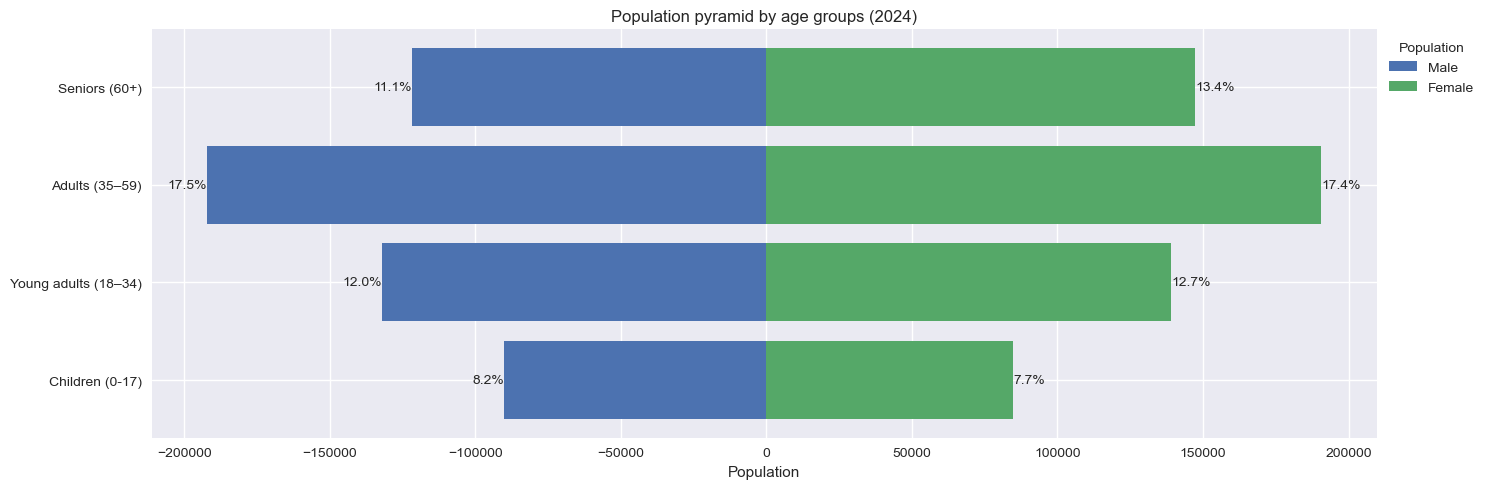

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))

y = np.arange(len(age_groups))

ax.barh(y, -male_counts, label="Male")
ax.barh(y, female_counts, label="Female")

total = male_counts.sum() + female_counts.sum()

for i, (m, f) in enumerate(zip(male_counts, female_counts)):
    ax.text(-m, i, f'{m/total*100:.1f}%', va='center', ha='right')
    ax.text( f, i, f'{f/total*100:.1f}%', va='center', ha='left')

ax.set_yticks(y)
ax.set_yticklabels(group_names)

ax.set_xlabel("Population")
ax.set_title(f"Population pyramid by age groups ({latest_year})")

plt.legend(title="Population", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

The 2024 population pyramid reflects a clearly aging structure. 

Child cohorts are relatively small, representing about 8% of males and 7.7% of females.

Adults aged 35-59 form the core of the population, accounting for 17.5% of males and 17.4% of females.

A pronounced female predominance appears among seniors, where women make up 13.4% compared with 11.1% for men.

## Nationality structure

### Non-german share over time

In [43]:
df_temp = df_city[['year', 'population_total', 'non_german_total', 'non_german_share', 'avg_age_german', 'avg_age_non_german', 'migration_background_total', 'migration_background_share', 'residents_with_migration_background_00_18']].copy()

df_temp['german_total'] = df_temp['population_total'] - df_temp['non_german_total']


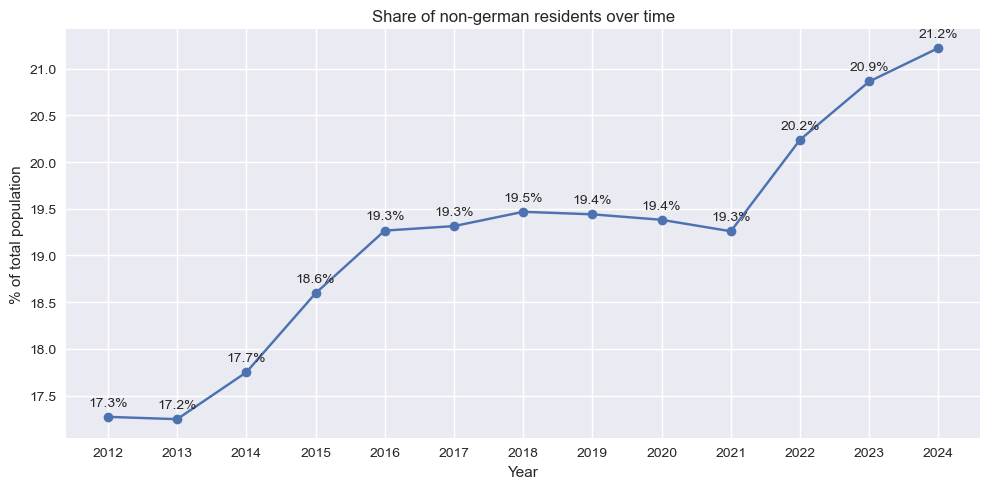

In [44]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['non_german_share'], marker='o')

for x, y in zip(df_temp['year'], df_temp['non_german_share']):
        ax.annotate(f"{y:.1f}%", (x, y), xytext=(0, 8), textcoords='offset points', ha='center')

ax.set_xlabel("Year")
ax.set_ylabel("% of total population")
ax.set_xticks(df_city['year'])
plt.title("Share of non-german residents over time")


plt.tight_layout()
plt.show()

The chart shows that:

- Non-german residents share increased over time, from 17.3% in 2012 to 21.2% in 2024.

- Growth was especially strong between 2014-2016 and again after 2021.

- In 2017-2020 the share remained almost stable (around 19.4%).

### Non-german share by district, latest year

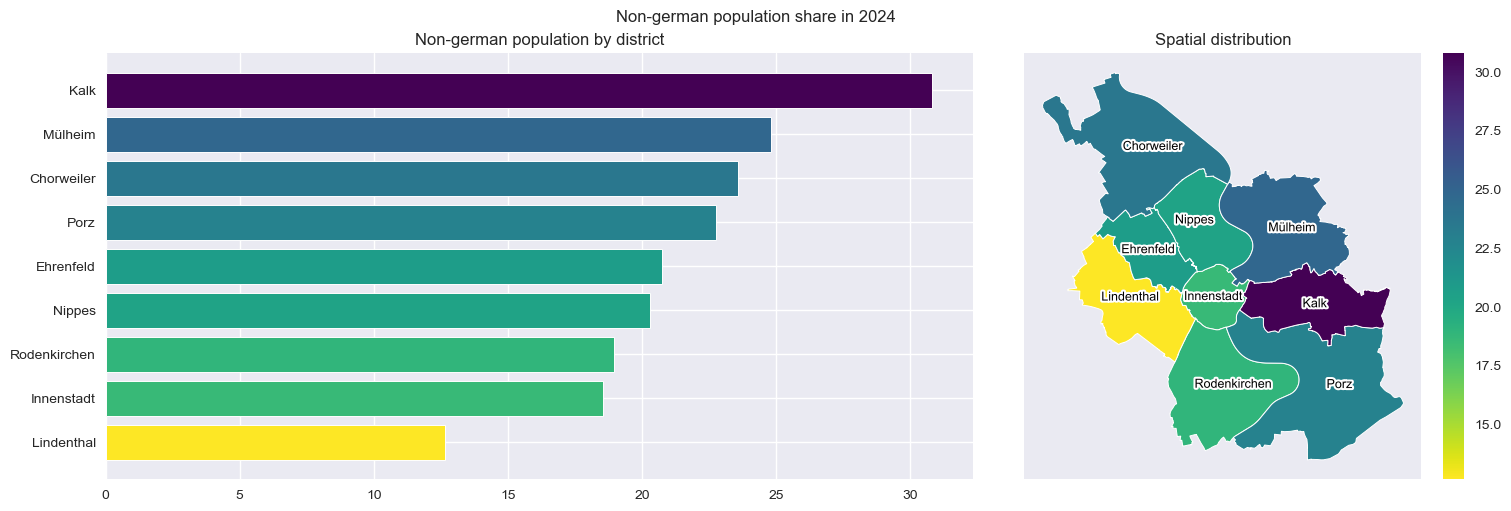

In [45]:
df_temp_dl = df_districts_latest.sort_values('non_german_share')

gdf_dl = gdf_d.merge(
    df_temp_dl[['area', 'non_german_share']],
    left_on='name',     
    right_on='area',  
    how='left'
    )

norm = mcolors.Normalize(
    vmin=df_temp_dl['non_german_share'].min(),
    vmax=df_temp_dl['non_german_share'].max()
)

cmap = plt.cm.viridis_r

fig, (ax_bar, ax_map) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True)

ax_bar.barh(
    df_temp_dl['area'], 
    df_temp_dl['non_german_share'],
    color=cmap(norm(df_temp_dl['non_german_share'])),
    edgecolor='white',
    linewidth=0.7
    )

ax_bar.set_title("Non-german population by district")


ax_map.add_patch(
    plt.Rectangle(
        (0,0), 1, 1, 
        facecolor="#EAEAF2", 
        transform=ax_map.transAxes, 
        zorder=-1)
    )

gdf_dl.plot(
    ax=ax_map,
    column='non_german_share',
    cmap=cmap,
    norm=norm,
    legend=True,
    edgecolor='white',
    linewidth=0.7,
    )

for _, row in gdf_dl.iterrows():
    x, y = row.geometry.representative_point().coords[0]
    ax_map.text(
        x, y,
        row['name'],
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        path_effects=[pe.withStroke(linewidth=3, foreground='white')]
    )

ax_map.set_title("Spatial distribution")
ax_map.axis("off")

fig.suptitle(f"Non-german population share in {latest_year}")

plt.show()



In [46]:
df_temp_dl.groupby('area')[['population_total', 'non_german_share']].apply(lambda x: x.mean()).sort_values('non_german_share', ascending=False)

,population_total,non_german_share
area,,
Kalk,122378.0,30.786579
Mülheim,150471.0,24.805444
Chorweiler,84079.0,23.563553
Porz,116483.0,22.756110
Ehrenfeld,111789.0,20.721180
Nippes,117688.0,20.278193
Rodenkirchen,112883.0,18.945280
Innenstadt,127813.0,18.556015
Lindenthal,153935.0,12.639101


The non-german population is distributed unevenly across districts.

Kalk has the hightest share at 30.8%, next in number are Mülheim (24.8%) and Chorweiler (23.6%). In contrast, Lindenthal shows the lowest proportion - 12.6%.

### Age struction comparison

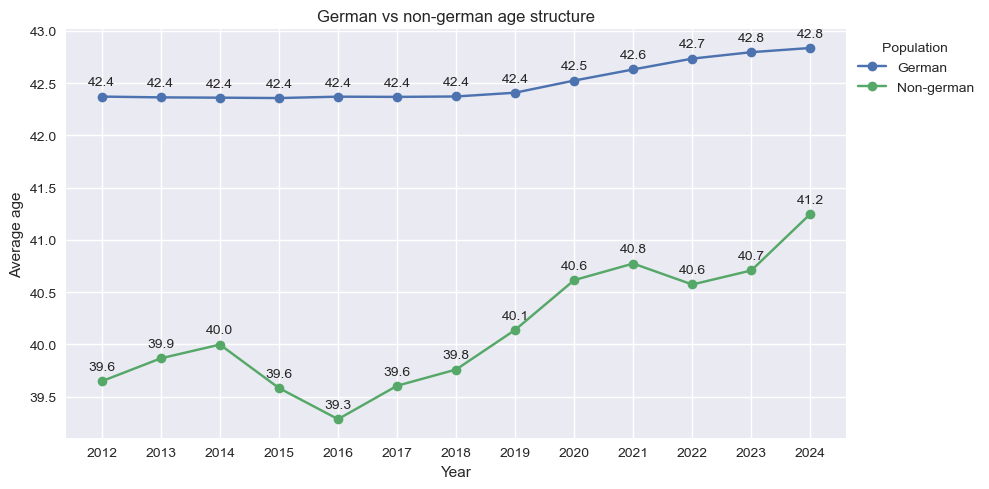

In [47]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['avg_age_german'], marker='o', label='German')
ax.plot(df_temp['year'], df_temp['avg_age_non_german'], marker='o', label='Non-german')

for x, y in zip(df_temp['year'], df_temp['avg_age_german']):
        ax.annotate(f"{y:.1f}", (x, y), xytext=(0, 8), textcoords='offset points', ha='center')

for x, y in zip(df_temp['year'], df_temp['avg_age_non_german']):
        ax.annotate(f"{y:.1f}", (x, y), xytext=(0, 8), textcoords='offset points', ha='center')

ax.set_xlabel("Year")
ax.set_ylabel("Average age")
ax.set_xticks(df_city['year'])
plt.title("German vs non-german age structure")

plt.legend(title="Population ", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [48]:
df_temp['age_gap'] = df_temp['avg_age_german'] - df_temp['avg_age_non_german']

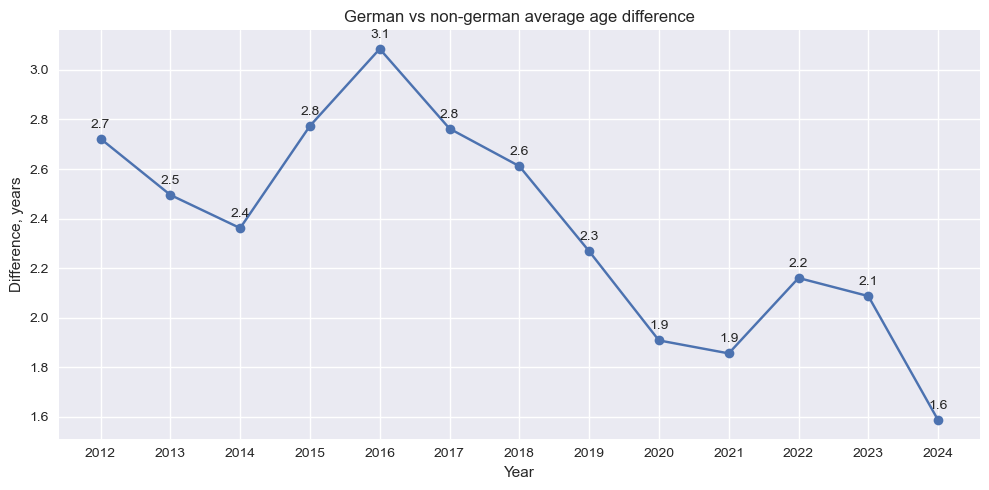

In [49]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['age_gap'], marker='o')

for x, y in zip(df_temp['year'], df_temp['age_gap']):
        ax.annotate(f"{y:.1f}", (x, y), xytext=(0, 8), textcoords='offset points', ha='center')

ax.set_xlabel("Year")
ax.set_ylabel("Difference, years")
ax.set_xticks(df_city['year'])
plt.title("German vs non-german average age difference")


plt.tight_layout()
plt.show()

The german population is consistently older than the non-german population.

Nevertheless, both groups show a gradual aging trend - age difference narrowed over time. It indicates that non-german population has aged faster or changed its structure.

### Foreign vs migration background comparison

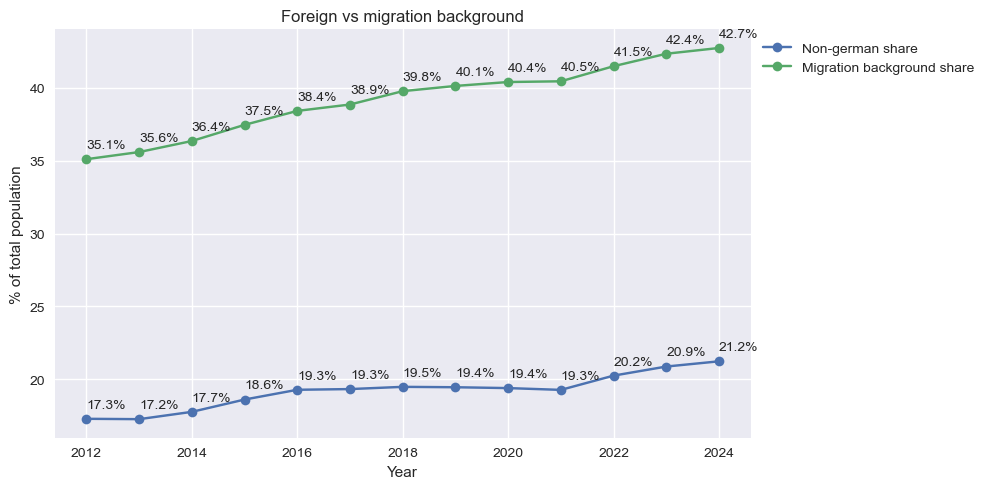

In [50]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['non_german_share'], marker='o', label='Non-german share')
ax.plot(df_temp['year'], df_temp['migration_background_share'], marker='o', label='Migration background share')

for x, y in zip(df_temp['year'], df_temp['non_german_share']):
    ax.annotate(f'{y:.1f}%', (x, y), xytext=(0,8), textcoords='offset points')

for x, y in zip(df_temp['year'], df_temp['migration_background_share']):
    ax.annotate(f'{y:.1f}%', (x, y), xytext=(0,8), textcoords='offset points')

ax.set_xlabel("Year")
ax.set_ylabel("% of total population")
ax.set_title("Foreign vs migration background")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

The migration background is much higher than non-german share.

The gap can be caused by naturalized citizen, german-born children of immigrants, etc.

#### Gap indicator

In [51]:
df_temp['migration_gap'] = df_temp['migration_background_share'] - df_temp['non_german_share']

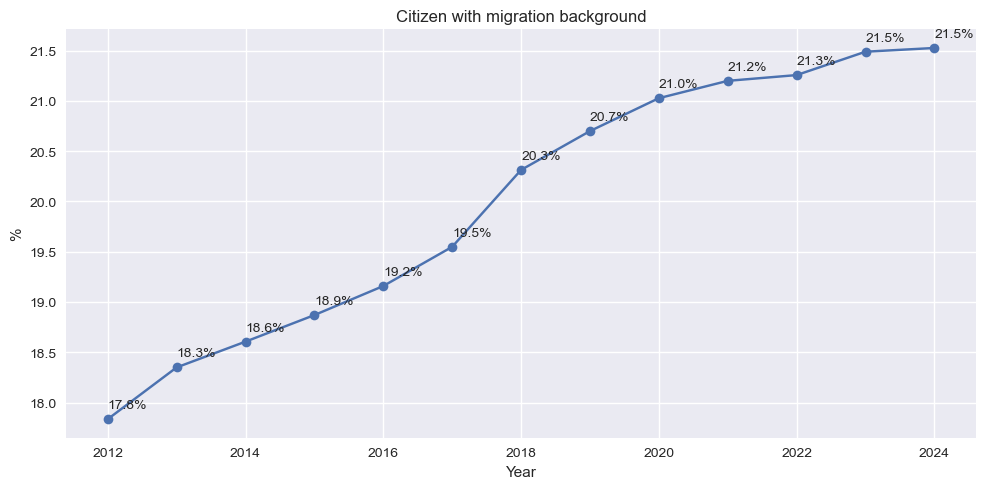

In [52]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['migration_gap'], marker='o')

for x, y in zip(df_temp['year'], df_temp['migration_gap']):
    ax.annotate(f'{y:.1f}%', (x, y), xytext=(0,8), textcoords='offset points')

ax.set_xlabel("Year")
ax.set_ylabel("%")
ax.set_title("Citizen with migration background")

plt.tight_layout()
plt.show()

The continuous rise indicates that naturalization and the birth of children to immigrant families play an increasingly important role in population composition.

#### Youth migration share

In [53]:
df_temp['youth_migration_share'] = df_temp['residents_with_migration_background_00_18'] / df_temp['migration_background_total'] * 100

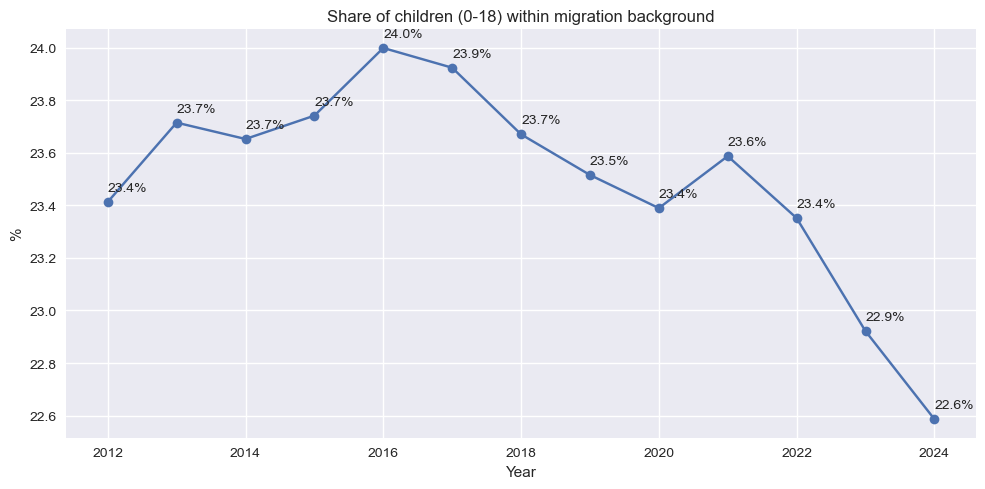

In [54]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['youth_migration_share'], marker='o')

for x, y in zip(df_temp['year'], df_temp['youth_migration_share']):
    ax.annotate(f'{y:.1f}%', (x, y), xytext=(0,8), textcoords='offset points')

ax.set_xlabel("Year")
ax.set_ylabel("%")
ax.set_title("Share of children (0-18) within migration background")

plt.tight_layout()
plt.show()

The sahre of children within the population with a migration background remained relatively stable around 23-24% over time. 

A small peak occured in 2016 (24%), followed by a gradual decline in 2024 (22.6%).

The decline can be caused by aging the population with a migration background.

## Population dynamics

### Natural demographic processes

#### Natural balance

In [70]:
df_temp['natural_balance'] = df_city['births'] - df_city['deaths']

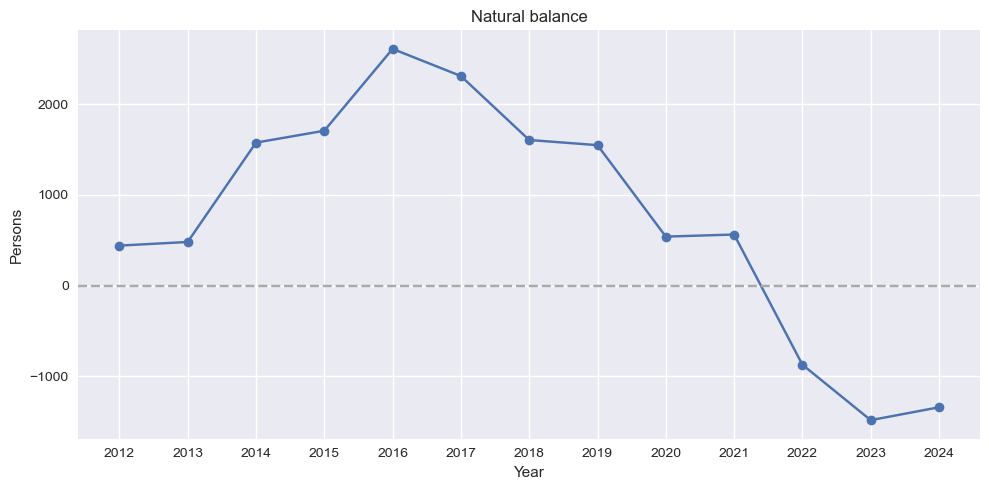

In [79]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['natural_balance'], marker='o')

ax.axhline(0, linestyle='--', color='darkgray')

ax.set_xlabel("Year")
ax.set_ylabel("Persons")
ax.set_xticks(df_city['year'])
plt.title("Natural balance")

plt.tight_layout()
plt.show()

#### Births vs deaths over time

In [76]:
df_temp['birth_rate_per_1000'] = df_city['births'] / df_city['population_total'] * 1000
df_temp['death_rate_per_1000'] = df_city['deaths'] / df_city['population_total'] * 1000

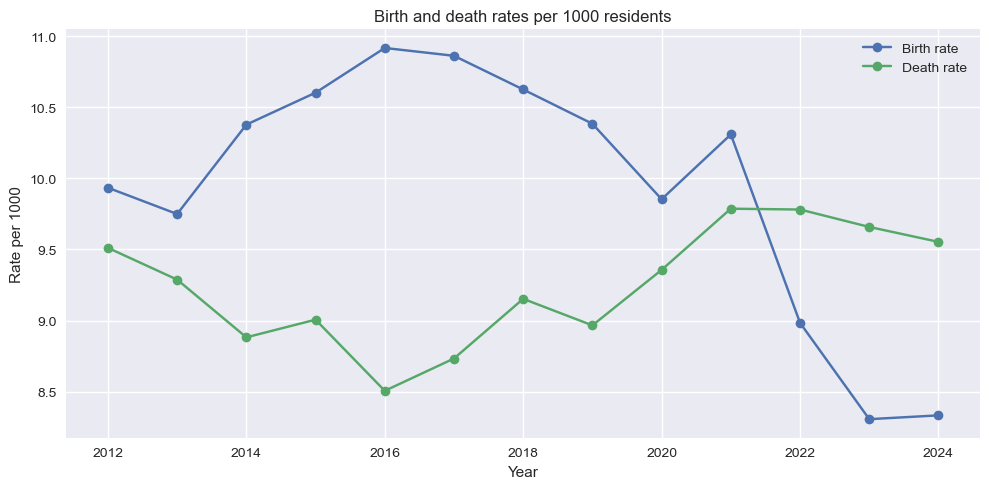

In [80]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['birth_rate_per_1000'], marker='o', label='Birth rate')
ax.plot(df_temp['year'], df_temp['death_rate_per_1000'], marker='o', label='Death rate')

ax.set_title("Birth and death rates per 1000 residents")
ax.set_xlabel("Year")
ax.set_ylabel("Rate per 1000")
ax.legend()

plt.tight_layout()
plt.show()

The both charts show the transition from natural growth to natural decline.

Until 2021 births clearly exceeded deaths, and peak natural surplus in 2016.

### Migration processes

In [82]:
df_temp = df_temp.assign(**df_city[['arrivals_total', 'arrivals_per_100', 'departures_total', 'departures_per_100']])

#### Mobility intensity

(how many people enter and leave the city)

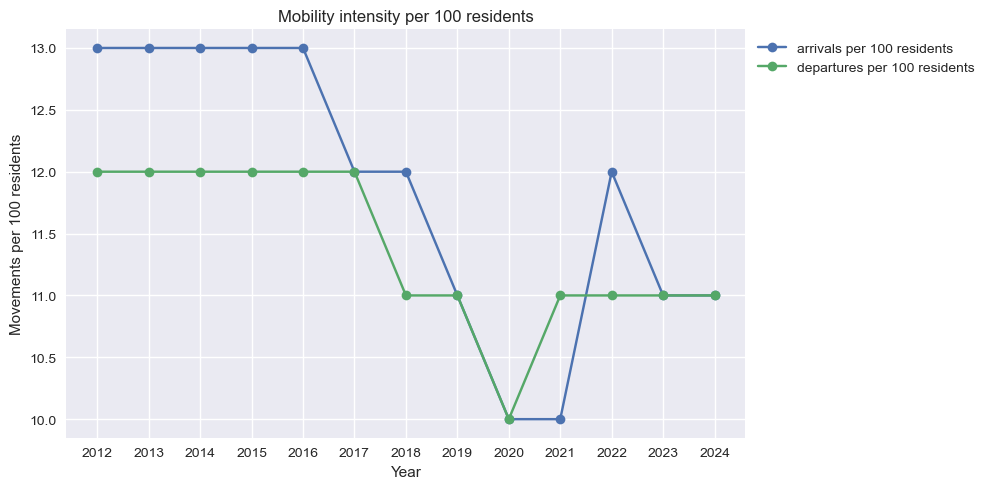

In [89]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['arrivals_per_100'], marker='o', label="arrivals per 100 residents")
ax.plot(df_temp['year'], df_temp['departures_per_100'], marker='o', label="departures per 100 residents")

ax.set_xlabel("Year")
ax.set_ylabel("Movements per 100 residents")
ax.set_xticks(df_city['year'])
plt.title("Mobility intensity per 100 residents")

plt.legend(title="", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

Mobility intensity shows next phases:

- 2012-2016 - very high inflow rates of around 13 arrivals per 100 residents;
  
- 2017-2021 - mobility stabilized at the lower level;
  
- 2022 - renewed peak.

#### Net migration

(the difference between the number of arrivals and departures - demographic effect)

In [84]:
df_temp['net_migration'] = df_temp['arrivals_total'] - df_temp['departures_total']

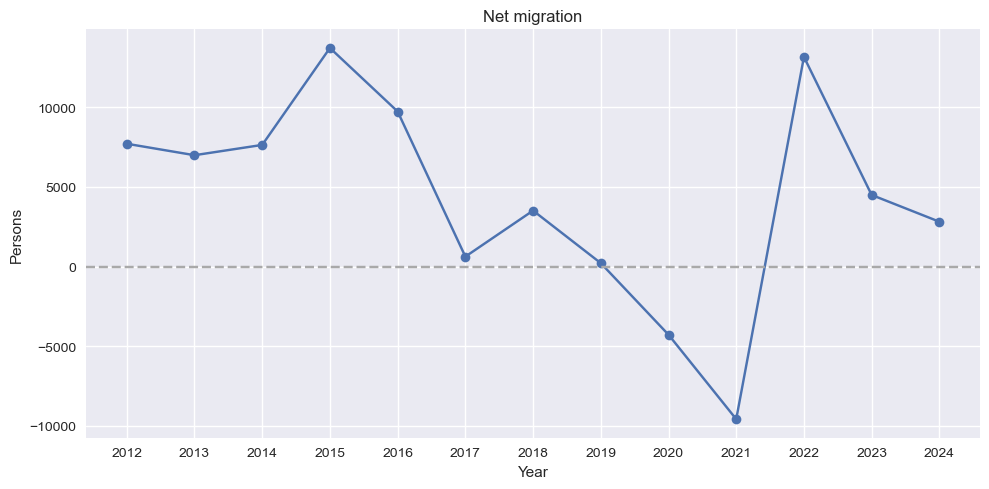

In [87]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['net_migration'], marker='o')

ax.axhline(0, linestyle='--', color='darkgray')

ax.set_xlabel("Year")
ax.set_ylabel("Persons")
ax.set_xticks(df_city['year'])
plt.title("Net migration")

plt.tight_layout()
plt.show()

Most years exhibit positive value, meaning that migration adds population to the city.

Only around 2020-2021 net migration was negative.

#### Demographic accounting

In [57]:
df_temp['delta_total'] = df_temp['population_total'].diff()
df_temp['delta_german'] = df_temp['german_total'].diff()
df_temp['delta_non_german'] = df_temp['non_german_total'].diff()

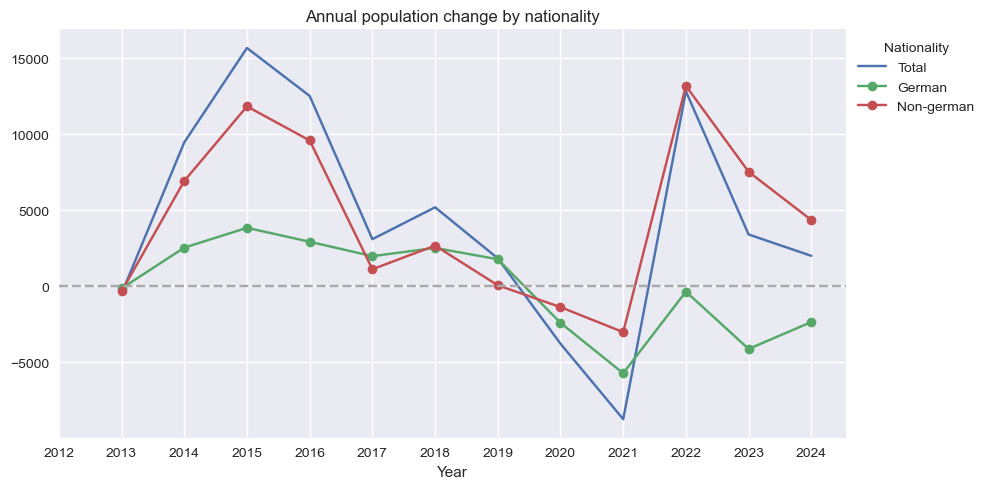

In [58]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['delta_total'], marker='', label="Total")
ax.plot(df_temp['year'], df_temp['delta_german'], marker='o', label="German")
ax.plot(df_temp['year'], df_temp['delta_non_german'], marker='o', label="Non-german")
plt.axhline(0, linestyle='--', color='darkgray')

ax.set_xlabel("Year")
ax.set_ylabel("")
ax.set_xticks(df_city['year'])
plt.title("Annual population change by nationality")

plt.legend(title="Nationality", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

Since 2015 almost all positive population growth was attributable to the non-german population, while the german population declined. 

This confirms the demographic renewal of the city relies primarily on migration.

#### Correlation between net migration and non-german change

In [60]:
crr = df_temp['net_migration'].corr(df_temp['delta_non_german'])

print(f"Correlation between net migration and non-german change: {crr:.2f}")

Correlation between net migration and non-german change: 0.88


Correlation is extremely strong. This confirms that migration movements are the primary reason behind the growth of the non-german population.

However, the relationship is not absolute, indicating presence of additional processes such as naturalization of non-german, demographic aging and other.

#### Naturalization

In [90]:
df_temp['naturalized_total'] = df_temp['migration_background_total'] - df_temp['non_german_total']

df_temp['naturalized_share'] = df_temp['naturalized_total'] / df_temp['migration_background_total'] * 100


df_temp['naturalized_change'] = df_temp['naturalized_total'].diff()

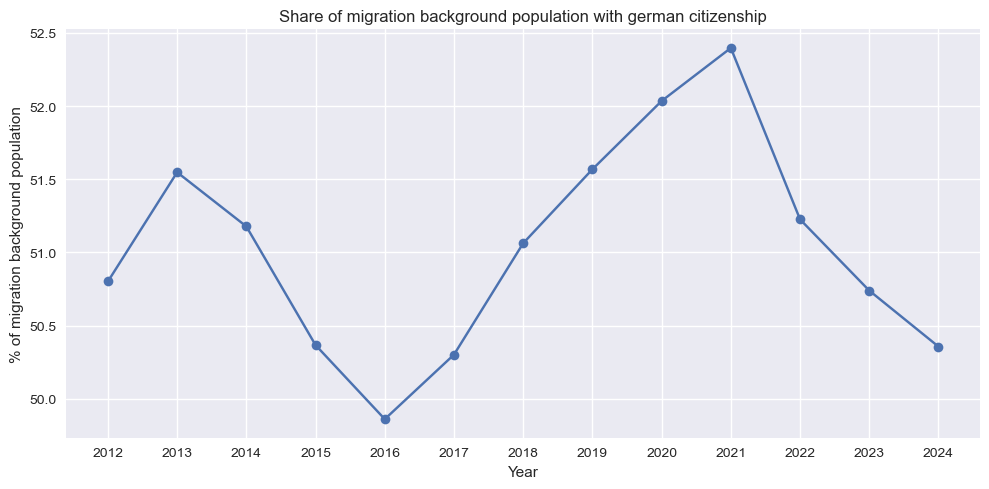

In [92]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_temp['year'], df_temp['naturalized_share'], marker='o')


ax.set_xlabel("Year")
ax.set_ylabel("% of migration background population")
ax.set_xticks(df_city['year'])
plt.title("Share of migration background population with german citizenship")

plt.tight_layout()
plt.show()

Roughly half of all residents with migration background hold german citizenship.

The chart shows next dynamics:

- Decline in 2014-2016 (large inflow of new foreigners)

- Rise until 2021 (naturalization of earlier migrants)

- Decline again after 2021 (new immigration wave)